# 080 Curve Fitting with Scikit-Learn

> COM6018

*Copyright &copy; 2023, 2024 Jon Barker, University of Sheffield. All rights reserved*.

## 1. Introduction

So far we have been using the Scikit-Learn package to perform **classification** tasks. The other main task in machine learning is **regression**. Here we wish to predict the value of one or more **continuous variables**.

Before we get into the details, it is worth considering how classification and regression differ:

In a **classification task**, we need to predict a class label. The class label can be represented as **a discrete variable**, i.e., an integer. However, more significantly, the label is also often a **nominal value**, i.e., a value that does not have a natural ordering. For example, the class labels for the iris data set, that we used earlier in the module, were `setosa`, `versicolor` and `virginica`. There is no natural ordering to these labels. We may have used the integers 0, 1 and 2 to represent these labels, but we could equally well have used the integers 2, 1 and 0. Integers are just a convenient way of representing labels.

In a **regression task**, we are predicting **a continuous value**. For example, we may want to predict the temperature for some given date in the future. Or, we may want to estimate some quantity that is hard to measure directly from a set of values that are more easily measured. For many problems the value being estimated will be a scalar value, i.e., a single value, but it could also be a vector. For example, we may wish to predict the position in space of a planet at some time in the future. In this case, we would be predicting a vector of three values, the $x$, $y$ and $z$ coordinates of the planet.

There are two important points to note about the above differences. First, unlike classification tasks, regression tasks do not have a fixed set of outcomes. This means that evaluation metrics such as percentage correct, and tools such as confusion matrices cannot be used. Second, for regression tasks, we can meaningfully talk about the 'closeness' of the predicted output to the true value (i.e., because the continuously valued outputs have a natural order.) So, we can evaluate the classifier by measuring the difference between the output and the true value. For example, we may use the mean squared error (MSE) or the mean absolute error (MAE). Note, that this idea of 'closeness' does not apply to classification tasks when the class labels are nominal values (if the true label is 'cat' then both 'dog' and 'duck' are equally wrong.).

In this tutorial, we will consider a particular type of regression problem, namely, fitting a curve through a set of data points. This is a very visual task that will help us to understand the key concepts. We will then be able to apply these ideas to more general regression problems in later tutorials. Furthermore, to keep things simple, we will consider data points that are plotted along a single axes (i.e., one `independent variable`, for example, a plot of $y$ against $x$). However, keep in mind that the ideas that we develop here can be extended to data points that are plotted in two or more dimensions (i.e., fitting a surface to a plot of $z$ against $x$ and $y$).

## 2. Curve Fitting and Data Modelling

Before getting into specifics, it is worth spending some time to consider what we are really doing when to try to fit a curve through a set of data points.

Curve fitting can be considered as a form of **data modelling**. We are drawing a curve in order to try and express a simple relationship between some input variable (i.e., the variable represented by the x axis) and an output value which is represented on the y axis.  For example, we may be trying to find the relationship between time and concentration of carbon dioxide in the atmosphere.

There are various reasons why we might want to be fitting a curve. We might want to be able to **extrapolate** into the future or back into the past. We might want to use the curve to **interpolate**, i.e., to estimate the value of $y$ for some $x$ for which we do not have a direct measurement. More generally, we might want to use curve fitting as a way to understand the mechanisms driving the relationship between the input and output variables. For example, if we can see that the data can be fitted with a periodically varying function, then the duration of the oscillations may give us some insight into the underlying mechanisms. Or, if we find that an exponential function fits the data, then this may give us some insight into the underlying processes; i.e., the growth rate being proportional to the current value tells us something about the mechanism that is driving the growth.

How do we fit a curve to some data? How will we decide which curve represents the best fit? What do we even mean by 'best'? These questions get to the heart of what we mean by 'modelling'. Obviously, we could draw some very wriggly line that goes precisely through all our measured data points and the curve would fit the measured data perfectly. In fact, there are an infinite number of wriggly lines that fit perfectly through any finite set of data points. All of these different curves would have different values if we interpolated or extrapolated. So, we need some way to choose between these, i.e., some precise way to say what we mean by 'best'. To do this we need to step back and consider the nature of the data that we are trying to model.

When we model data, we work on the assumption that the output variable is made up of two components: **a deterministic component** and **a stochastic component**. The deterministic component is the part of the output variable that we can predict from the input variable. The stochastic component is the part of the output variable that we cannot predict, i.e. it is essentially random. Our model is an attempt to capture the deterministic component of the data. We will further assume that the deterministic component can be represented using a relatively simple function, and our job is to find the simplest function that captures this component accurately.

For example, consider the case of carbon dioxide concentration in the atmosphere. There is an underlying growth trend the comes from the burning of fossil fuels that drives the concentration upwards in a smooth way. In addition, there is also a seasonal variation due to the way that plants and trees absorb more carbon dioxide in the summer and less in winter. These two effects can be modelled with a curve that is controlled by a small number of parameters. For example, a parameterised quadratic curve to model the growth and a sinusoidal function with a parameterised amplitude to model the seasonal variation. However, if you look at the data, you will notice that the precise readings bounce up and down by a small amount every day. This is the stochastic component. It is not possible to predict these fluctuations from the input variable (time). They are due to all sorts of random fluctuations, e.g., fluctuations in the weather around the measurement station, and physical effects in the measurement instruments themselves. Fortunately, as we will see in this tutorial, because these random fluctuations behave very differently from the underlying trends, they do not prevent us estimating the trend parameters.

Note that in the example above, we required some understanding of the problem to design a model. Our understanding led us to combine a smooth growth curve with a sinusoidal curve for seasonal variation. In general, because the space of possible 'models' is huge, this type of domain knowledge is essential to guide us to a good model. However, regardless of our understanding of the problem, our basic strategy is the same. We will start out with a very simple model, and then gradually make it more complex until we have a model that fits the data well. The aim will always be to find the simplest model that fits the data well.

## 3. Some toy data sets

To illustrate the ideas above, we will use some toy data sets. These data will not be from real problems, but will be artificially created by taking simple functions and then adding some random noise. This will allow us to easily evaluate how well the models perform because we will know the true function that generated the data. In the lab class, you will use the same techniques, but apply them to a real world dataset.

We will look at two different types of data,

- polynomial data, where the data are generated from a polynomial function, and
- periodic data, where the data is generated from a periodic function.

In the lab class, the data will require a model that combines polynomial and periodic functions.

We will start with polynomial data. We will generate data for polynomials up to 4th order, i.e., linear, quadratic, cubic, and quartic functions. We will use the following function to generate the data,

In [1]:
def polynomial(x, a, b, c, d, e, noise=0.0):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + noise*np.random.randn(len(x))

Note that we can produce lower-order polynomials by setting the higher-order coefficients to zero. For example, to generate a quadratic function, we would set `c` and `d` to zero. The function contains a noise term with a scale factor `noise` that adds a noise component to each term in the sequence. The noise is drawn from a normal distribution, independently for each data point.

For periodic data, we will consider functions that are constructed from the sums of sine and cosine functions. These functions will have terms $\sin(Ax)$ and $\cos(Bx)$ where $A$ and $B$ are integers. **Fourier theory** tells us that any periodic function can be represented as a sum of sine and cosine functions in this way, if we use enough terms. To keep things simple, we will used functions with values of $A$ and $B$ in the range of 1 to 3.

We will use the following function to generate the data,

In [2]:
def periodic(x, s1, s2, s3, c1, c2, c3, noise=0.0):
    return s1*np.sin(x) + s2*np.sin(2*x) + s3*np.sin(3*x) + c1*np.cos(x) + c2*np.cos(2*x) + c3*np.cos(3*x) + noise*np.random.randn(len(x))

Note that as with our polynomial generator, we have included a noise term so that we can model real data that are not perfectly predictable.

We will now use our functions to generate some data. We will generate 50 data points for each of our polynomial functions and 100 data points for each of our periodic functions. We will use the `numpy` function `linspace` to generate the input values. This function generates a sequence of values between a start and end value. We will use the start value of -5 and the end value of 5 for the polynomials and a range of -10 to 10 for the periodic functions. The noise parameters have been tuned to add a small amount of random noise to the data, enough to make the estimation problem interesting but not so much that the deterministic component of the data is totally obscured.

In [3]:
import numpy as np
x1 = np.linspace(-5, 5, 50)
poly1 = polynomial(x1, 2.0, -1.5, 0, 0, 0, noise=0.3)
poly2 = polynomial(x1, 2.0, -1.5, 0.8, 0, 0, noise=1.0)
poly3 = polynomial(x1, 2.0, -1.5, 2.2, -1.7, 0, noise=10)
poly4 = polynomial(x1, -10, 0.8, 5.5, -0.01, -0.21, noise=2.0)

x2 = np.linspace(-10, 10, 100)
periodic1 = periodic(x2, -1.0, 0, 0, 0.5, 0, 0, noise=0.1)
periodic2 = periodic(x2, 1.0, -0.5, 0, 0.5, 0.2, 0, noise=0.1)
periodic3 = periodic(x2, 1.0, -0.5, -0.2, 0.5, -0.8, 0.3, noise=0.1)

We can plot the data using the `matplotlib` library. The polynomials are show below.

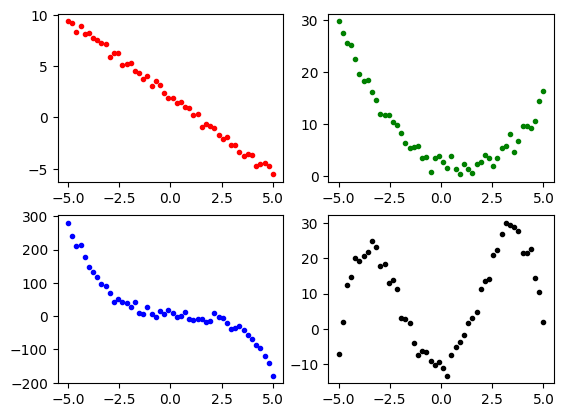

In [4]:
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
plt.plot(x1, poly1, 'r.')
plt.subplot(2, 2, 2)
plt.plot(x1, poly2, 'g.')
plt.subplot(2, 2, 3)
plt.plot(x1, poly3, 'b.')
plt.subplot(2, 2, 4)
plt.plot(x1, poly4, 'k.')
plt.show()

The periodic data look like this.

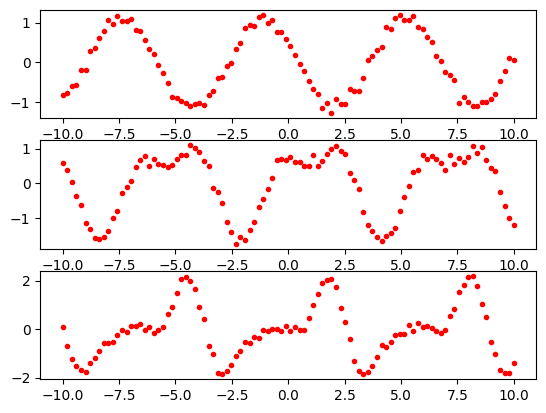

In [5]:
import matplotlib.pyplot as plt
plt.subplot(3, 1, 1)
plt.plot(x2, periodic1, 'r.')
plt.subplot(3, 1, 2)
plt.plot(x2, periodic2, 'r.')
plt.subplot(3, 1, 3)
plt.plot(x2, periodic3, 'r.')
plt.show()

For convenience later, we are going to reshape our `x1` and `x2` axes data so that the values are stored in a 2D numpy array but with one dimension having a size of 1. This will make it easier to use the data with the `scikit-learn` library. The code for doing this is shown below.

In [6]:
x1 = np.expand_dims(x1, axis=1)
x2 = np.expand_dims(x2, axis=1)

```{note}
If the above step confuses you, look at the `shape` of `x1` and `x2` before and after the `expand_dims` step. For example, you will see that the shape of `x1` changes from `(50,)` to `(50, 1)`.
```

## 4. Fitting a curve

We will start out by considering how to fit curves to the polynomial data.

In the first instance, we start with the simplest possible model: a straight line. To do this, we will use the `LinearRegression` class from the `sklearn.linear_model` module. We will first try fitting a straight line to our `poly1` data. This will work well because the underlying function actually was a straight line.

The code looks like this;

In [7]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
model = linear_model.fit(x1, poly1)

In the above, the `fit` method does the work of calculating the best straight-line fit. It takes the $x$ and $y$ points from the original data, i.e., `x1` and `poly1`, in our case.

The `fit` method returns a model that stores the parameters of the linear fit. These parameters are stored in the `coef_` and `intercept_` attributes. We can print these out to see what they are,

In [8]:
print(model.coef_)
print(model.intercept_)

[-1.50543901]
2.027425716319223


This can be understood as follows. The linear model is given by the equation $y = mx + c$, where $m$ is the slope of the line (stored as `coef_`) and $c$ is the intercept (stored as `intercept_`). If you look back to where we generated the data, you will see that the real equation was $y = -1.5x + 2.0$. It turns out that the estimated values for $m$ and $c$ are very close to the true values, -1.5 and 2.0, which were used to generate the data. So, the model has done a pretty good job of estimating the parameters despite the added noise.

We can now look at this visually by plotting the data points and the fitted line. To do this, we will use the `predict` method of the model. This method takes a set of $x$ values and returns the corresponding $y$ values. We can then plot the original data points and the fitted line on the same plot.

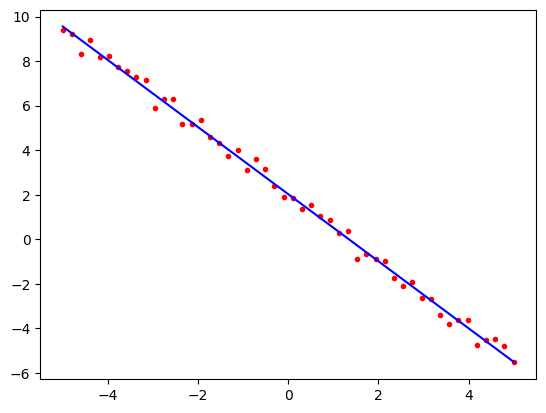

In [9]:
import matplotlib.pyplot as plt
predicted = model.predict(x1)
plt.plot(x1, poly1, 'r.')
plt.plot(x1, predicted, 'b-')
plt.show()

Note how the line passes very close to all of the data points. The mathematics of linear regression tells us that of all the possible straight lines, this particular line is the one that comes closest to the points on average if our measure of closeness is the squared distance between the line and the points. This is why it is also called the **least squares fit**.

### 4.1 Underfitting a curve

Let us now repeat this exercise but this time we will use our 3rd order polynomial data (poly3) which was made from a sum of linear, quadratic and cubic functions. We will use the same straight line model as before.

In [10]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
model = linear_model.fit(x1, poly3)

Now let us plot the result,

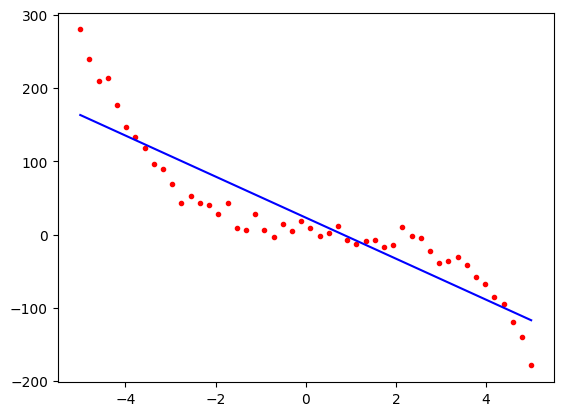

In [11]:
import matplotlib.pyplot as plt
predicted = model.predict(x1)
plt.plot(x1, poly3, 'r.')
plt.plot(x1, predicted, 'b-')
plt.show()

Notice now that although the blue predicted line follows the general trend of the red points, it is a long way from the data in some places. This is not a good fit. It is the best straight line that we could have plotted, but our model was too simple. We say that the model is **underfitting** the data. We need to use a more complex model.

Again, we can look at the parameters of the model.

In [12]:
print(model.coef_)
print(model.intercept_)

[-28.01679719]
23.087532475101266


This means that the line we have estimated has the equation,

$y = -27.7 x + 18.2$

If you look at the parameters that generated the `poly3` data, you will see that the correct equation is

$y = -1.7 x^3 + 2.2 x^2 - 1.5 x + 2.0$

Note that although we have found the best straight line fit, even the linear and intercept parameters are a long way from the correct values.

### 4.2 Fitting a polynomial curve

Let us now try estimating the parameters for the third-order polynomial using a model with linear, quadratic, and cubic terms. Somewhat confusingly, this is also done using a linear regression model but now we will be looking for the linear sum of powers of x, i.e. we are looking for an equation of the form

$y = a + bx + cx^2 + dx^3$

Here, $x$, $x^2$ and $x^3$ are fixed data values. The things were are looking for are the coefficients $a$, $b$, $c$ and $d$ which are being linearly combined, i.e. just scaled and summed. So in terms of the *parameters*, this is still a linear model.

To fit this model, we will need to generate some new features to represent the $x$, $x^2$ and $x^3$ terms. We can do this most conveniently by using the `PolynomialFeatures` class from the `sklearn.preprocessing` module. This class takes the original data, `x1`, and generates a new set of data that is the original data raised to the powers 1, 2, 3, etc. We can then use the linear regression model to fit these new data.

The code will work in two steps. First we make the features,

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
x_poly = poly.fit_transform(x1)

`x_poly` will be a 2-D array with the same number of rows as the original `x1` but with a separate column for each of the 3 powers of $x$. We can look at `x_poly` to verify that this is really the case, i.e., looking at the first 5 rows,

In [14]:
print(x_poly[0:5,:])

[[  -5.           25.         -125.        ]
 [  -4.79591837   23.00083299 -110.31011738]
 [  -4.59183673   21.0849646   -96.81871499]
 [  -4.3877551    19.25239484  -84.47479367]
 [  -4.18367347   17.5031237   -73.22735425]]


Now, we use these features to fit the model in much the same way as we did when using the `x1` data by alone.

In [15]:
from sklearn.linear_model import LinearRegression
poly_reg_model = LinearRegression()
model = poly_reg_model.fit(x_poly, poly3)

Now we can look at the model parameters as before,

In [16]:
print(model.coef_)
print(model.intercept_)

[-2.01851269  2.18181814 -1.66613856]
4.163599612290138


Note how the `coef_` variable is now an array of 3 numbers. These are the coefficients for the linear, quadratic, and cubic terms. The `intercept_` variable has the same meaning as before. So, the equation for the model is

$y = -1.8 x^3 + 2.1 x^2 - 0.6 x + 3.4$

We can compare this to the original equation,

$y = -1.7 x^3 + 2.2 x^2 - 1.5 x + 2.0$

and see that the model has done a pretty good job of estimating the parameters. It is more enlightening to look at the plot,

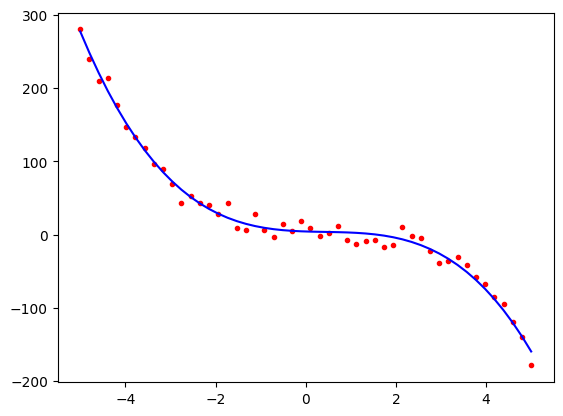

In [17]:
import matplotlib.pyplot as plt
predicted = model.predict(x_poly)
plt.plot(x1, poly3, 'r.')
plt.plot(x1, predicted, 'b-')
plt.show()

We can see that visually, this is a pretty good fit to the data despite the fact that the model's estimates of the linear and intercept parameters were a little bit different from the true values. Note that the curve is dominated by the cubic and quadratic terms, so the errors in the linear and intercept parameters do not have a big effect compared to the range of -200 to +300 on the $y$ axis.

### 4.3 Overfitting a polynomial curve

Now that we have seen how to fit higher-order polynomial curves, we can look at what happens when a model is too complicated for the underlying data is chosen.  For this example, we will take our 2nd-order polynomial data (`poly2`) and fit it with a 2nd-order polynomial model but then again with a 22nd-order polynomial, which has far too many parameters.

Looking back, we can see that the `poly2` data was generated from the equation,

$y = 0.8 x^2 - 1.5 x + 2.0$

We will start with the 2nd order model. This is the correct model for the data and so we should expect to get a good fit. In the following, we have performed the model estimation and plotting in a single cell,

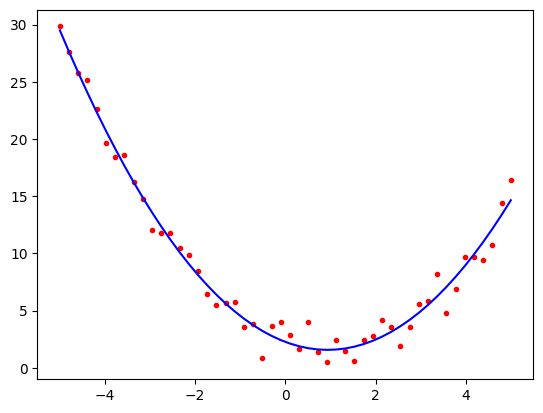


[-1.48552038  0.79243853]
2.262811946302371


In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(x1)
from sklearn.linear_model import LinearRegression
poly_reg_model = LinearRegression()
model = poly_reg_model.fit(x_poly, poly2)

import matplotlib.pyplot as plt
predicted = model.predict(x_poly)
plt.plot(x1, poly2, 'r.')
plt.plot(x1, predicted, 'b-')
plt.show()
print()
print(model.coef_)
print(model.intercept_)

The coefficients are close to the original values and the plot looks good, i.e. the estimated curve is $y = 0.8 x^2 -1.4 x + 2.1$

Now let us try fitting with a model that is too complicated. We will try with a 22nd order polynomial. We will use the same code as before, but change the degree parameter to 22. A function called `fit_with_degree_n` has been defined to make this easier, i.e., so that we do not have to cut and paste the same code when comparing the 2nd and 22nd order curves.

In [19]:
def fit_with_degree_n(y, x, n):
    poly = PolynomialFeatures(degree=n, include_bias=False)
    x_poly = poly.fit_transform(x)
    poly_reg_model = LinearRegression()
    model = poly_reg_model.fit(x_poly, y)
    predicted = model.predict(x_poly)
    return predicted

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

predicted2 = fit_with_degree_n(poly2, x1, 2)
predicted22 = fit_with_degree_n(poly2, x1, 22)

We can now plot the results.

``` python {cmd, continue=overfit, matplotlib=True}
plt.plot(x1, poly2, 'r.')
plt.plot(x1, predicted2, 'g-')
plt.plot(x1, predicted22, 'b-')
plt.show()
```

The green line is the correct second-order polynomial. The blue line is the 22nd order polynomial. We can see that the blue line is a very good fit to the actual data; however, it is not a good model because it is too complicated. It is highly influenced by the noise and is not a good predictor of the underlying function.

The problems of overfitting become a lot clearer if we try to use this model to extrapolate outside the range of the original data. This can be seen in the following:

``` python {cmd, continue=overfit, matplotlib=True}

def fit_with_degree_n(y, x, x_pred, n):
    poly = PolynomialFeatures(degree=n, include_bias=False)
    x_poly = poly.fit_transform(x)
    x_pred_poly = poly.fit_transform(x_pred)
    poly_reg_model = LinearRegression()
    model = poly_reg_model.fit(x_poly, y)
    predicted = model.predict(x_pred_poly)
    return predicted

# Make a range for the predictions that extends beyond the range of the observed data.
x_extrapolate = np.linspace(-5.2, 5.2, 50)
x_extrapolate = np.expand_dims(x_extrapolate, axis=1)

predicted2 = fit_with_degree_n(poly2, x1, x_extrapolate, 2)
predicted22 = fit_with_degree_n(poly2, x1, x_extrapolate, 22)

plt.plot(x1, poly2, 'r.')
plt.plot(x_extrapolate, predicted2, 'g-')
plt.plot(x_extrapolate, predicted22, 'b-')
plt.show()
```

In the above, we have made predictions between -5.2 and 5.2, so just moving a fraction beyond the range where the data lie (-5.0 to 5.0). Notice how the predicted values for the overfitted curve (blue) fit the red data points very well in the -5.0 to 5.0 region but then suddenly start to dramatically diverge from the actual data. This is a symptom of overfitting.

## 5. Fitting a periodic curve

We will now look at fitting a curve to our periodic data. Our main purpose here is to show that, by using Scikit-Learn, our code will look very similar to the code in the previous section.

We will use the datasets `periodic1`, `periodic2` and `periodic3` that we constructed earlier. We have replotted them below.

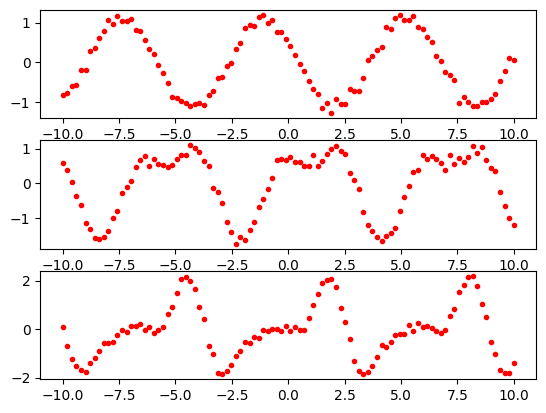

In [20]:
import matplotlib.pyplot as plt
plt.subplot(3, 1, 1)
plt.plot(x2, periodic1, 'r.')
plt.subplot(3, 1, 2)
plt.plot(x2, periodic2, 'r.')
plt.subplot(3, 1, 3)
plt.plot(x2, periodic3, 'r.')
plt.show()

We will start with the simplest possible model, a straight line. We will use the same linear regression fitting approach as before.

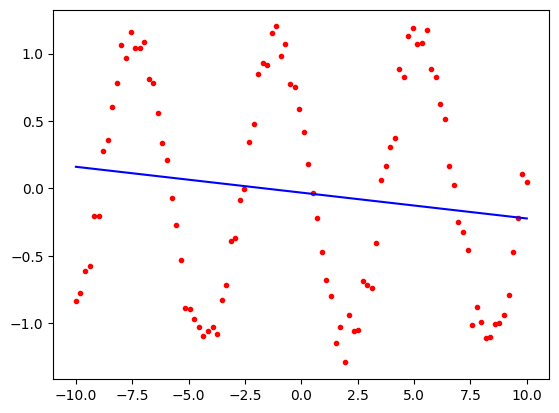

In [21]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
model = linear_model.fit(x2, periodic1)

import matplotlib.pyplot as plt
predicted = model.predict(x2)
plt.plot(x2, periodic1, 'r.')
plt.plot(x2, predicted, 'b-')
plt.show()

Unsurprisingly, this is a poor fit. We will now use a model that is a sum of sine and cosine functions that mirrors the way in which the data were actually generated. We will use the same approach as before, but instead of the model being.

$y = a + bx + cx^2 + dx^3$

it will be

$y = a\sin(x) + b\cos(x) + c\sin(2x) + d\cos(2x) + e\sin(3x) + f\cos(3x)$

For the polynomial model we could use the `PolynomialFeatures` class to make the array storing $x$, $x^2$, $x^3$, etc. For the periodic model, we will need to have an array storing $\sin(x)$, $\cos(x)$, $\sin(2x)$, etc. There is no class to do this for us, so we will have to construct the array ourselves using NumPy. The code for doing this is shown below.

In [22]:
def periodic_features(x):
    return np.concatenate((np.sin(x), np.cos(x), np.sin(2*x), np.cos(2*x), np.sin(3*x), np.cos(3*x)), axis=1)

The function takes the $x$ data and returns an array with the same number of rows but with 6 columns. The columns are the sine and cosine of $x$, $2x$ and $3x$. We can use this function to create the features and then use the `LinearRegression` class to fit the model to the data, as before.

So for the simplest dataset, `periodic1`, it will look like this

In [23]:
x_periodic = periodic_features(x2)
from sklearn.linear_model import LinearRegression
periodic_reg_model = LinearRegression()
model = periodic_reg_model.fit(x_periodic, periodic1)

If we examine the model, we will see that it has six coefficients, one for each of the sine and cosine terms.

In [24]:
print(model.coef_)

[-0.99224552  0.50439486 -0.00676821 -0.00135036  0.02238299  0.00115742]


Note how coefficients 3 to 6 are close to zero. This is because the `periodic1` data was made only from $\sin(x)$ and $\cos(x)$ terms.

We can now examine the fit by plotting the data points and the predicted values.

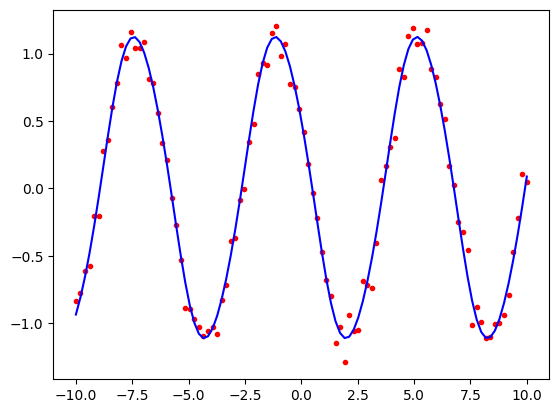

In [25]:
import matplotlib.pyplot as plt
predicted = model.predict(x_periodic)
plt.plot(x2, periodic1, 'r.')
plt.plot(x2, predicted, 'b-')
plt.show()

Let us repeat the exercise with the more complicated `periodic3` data that used all six cosine and sine terms.

In [26]:
x_periodic = periodic_features(x2)
from sklearn.linear_model import LinearRegression
periodic_reg_model = LinearRegression()
model = periodic_reg_model.fit(x_periodic, periodic3)

Now none of the coefficients are close to zero.

In [27]:
print(model.coef_)

[ 1.0114231   0.50578808 -0.4859283  -0.80482477 -0.17822469  0.32477556]


Plotting the predicted values against the data points shows that the model has done a good job of fitting the data.

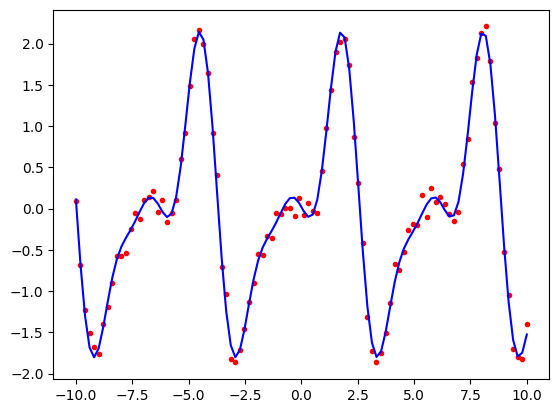

In [28]:
import matplotlib.pyplot as plt
predicted = model.predict(x_periodic)
plt.plot(x2, periodic3, 'r.')
plt.plot(x2, predicted, 'b-')
plt.show()

Let us now see what happens if we try to overfit. We will first rewrite our periodic_features function so that it can generate a sequence of cosine and sine terms up to any given order, i.e. $\sin(x)$, $\sin(2x)$, ..., $\sin(nx)$ and similarly for cosine.

In [29]:
def periodic_features_order_n(x, n):
    sin_features = [np.sin(x*i) for i in range(1, n+1)]
    cos_features = [np.cos(x*i) for i in range(1, n+1)]
    return np.concatenate(sin_features + cos_features, axis=1)

We will now use this function to fit first with order 3 and then with order 30.

In [30]:
x_periodic_3 = periodic_features_order_n(x2, 3)
x_periodic_30 = periodic_features_order_n(x2, 30)

from sklearn.linear_model import LinearRegression
periodic_reg_model3 = LinearRegression()
model_3 = periodic_reg_model3.fit(x_periodic_3, periodic3)

periodic_reg_model30 = LinearRegression()
model_30 = periodic_reg_model30.fit(x_periodic_30, periodic3)

We can now plot the results.

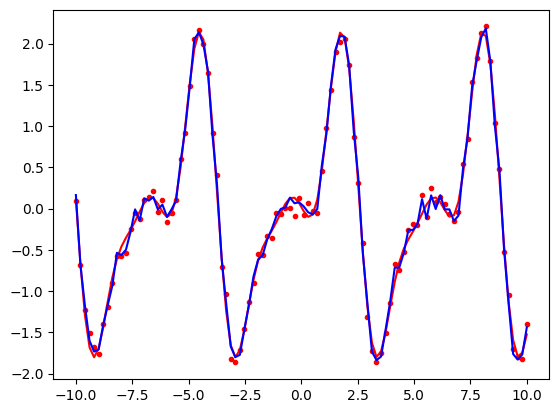

In [31]:
import matplotlib.pyplot as plt
predicted_3 = model_3.predict(x_periodic_3)
predicted_30 = model_30.predict(x_periodic_30)
plt.plot(x2, periodic3, 'r.')
plt.plot(x2, predicted_3, 'r-')
plt.plot(x2, predicted_30, 'b-')

plt.show()

The red curve is using the correct model parameters (i.e., the parameters that were used to produce the original data that we would not normally know.) Note how it is a smooth line that passes close to the data points. The blue curve which is using our 30th order model is too complicated. It produces a curve that passes very close to the data points but is not smooth. It captures random variation in the training data that is unlikely to be the same in future periods. We will explore this in more detail in the lab class.

## 6. Summary

We have used Scikit-Learn's `LinearRegression` class to fit curves to data using models based on either a sum of powers of $x$ or on a sum of sine and cosine functions. The curves that we are predicting are not straight lines, but the technique for fitting them is **linear regression** because the parameters that we are estimating are linearly combined. We have seen that if we use a model that is too simple, we will **underfit** the data. The model will lack sufficient complexity to mirror the real data leading to poor estimates even in regions where we have observations (i.e., in regions of the $x$-axis that are close to observed points). Alternatively, if we use a model that is too complex, we will **overfit** the data. The model will be too sensitive to the noise in the data and will not generalise well to new data (i.e., we will not be able to **extrapolate** or **interpolate** well).

It should also be noted, that successful fitting of the curve required having a good model in the first place. This is known as the **model selection** problem. For example, if our data are periodic in nature, then no polynomial model will ever be able to fit it well. Similarly, if the data is polynomial in nature, then no periodic model will ever be able to fit it well. In general, we need to have some understanding of how the data have been generated in order to be able to choose a good model. This is why **domain knowledge** is so important in machine learning.

In the lab class we will be making a model that has a mixture of polynomial and periodic components to model concentrations of gases in the atmosphere. We will then use our model to make some simple predictions about the future. We will see that this sophisticated analysis is quite straightforward to achieve using the techniques that we have learnt in this tutorial.